<BR>
<BR>
<center>
<font style="font-size:34px">Exploring Explanations for <BR><BR>Matrix Factorization Recommender Systems<BR><BR><BR>
</font>
<BR><BR>
<font style="font-size:20px">
FATREC 2017
<BR><BR>
August 31, 2017
<BR><BR><BR><BR><BR>
Bashir Rastegarpanah, Mark Crovella, and Krishna P. Gummadi
<BR><BR><BR>
This talk is available at <span style="font-family: monospace;">https://github.com/mcrovella/FATREC-2017-Talk</span>
<table style="border-style: hidden">
<tr>
<td style="border-style: hidden; padding: 30px"><IMG src='images/BUlogo.png' width=150/></td>
<td style="border-style: hidden; padding: 30px"><IMG src='images/mpi-sws-logo.svg' width=225/></td>
<td style="border-style: hidden; padding: 30px"><IMG src='images/nsf-logo.jpg' width=150/></td>
</tr>
</table>
<BR>
</center>

In [445]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
# import libraries
import numpy as np
import pandas as pd
import slideUtilities as sl
from importlib import reload
from datetime import datetime
import matplotlib as mp
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.display import display_html
from IPython.display import display
from IPython.display import Math
from IPython.display import Latex
from IPython.display import HTML
print('')

In [446]:
%%html
<style>
 .container.slides .celltoolbar, .container.slides .hide-in-slideshow {
    display: None ! important;
}
</style>

%Set up useful MathJax (Latex) macros.
%See http://docs.mathjax.org/en/latest/tex.html#defining-tex-macros
%These are for use in the slideshow
$\newcommand{\mat}[1]{\left[\begin{array}#1\end{array}\right]}$
$\newcommand{\vx}{{\mathbf x}}$
$\newcommand{\hx}{\hat{\mathbf x}}$
$\newcommand{\vbt}{{\mathbf\beta}}$
$\newcommand{\vy}{{\mathbf y}}$
$\newcommand{\vz}{{\mathbf z}}$
$\newcommand{\R}{{\mathbb{R}}}$
$\newcommand{\vu}{{\mathbf u}}$
$\newcommand{\vv}{{\mathbf v}}$
$\newcommand{\vw}{{\mathbf w}}$
$\newcommand{\col}{{\operatorname{Col}}}$
$\newcommand{\nul}{{\operatorname{Nul}}}$
$\newcommand{\vb}{{\mathbf b}}$
$\newcommand{\va}{{\mathbf a}}$
$\newcommand{\ve}{{\mathbf e}}$
$\newcommand{\setb}{{\mathcal{B}}}$
$\newcommand{\rank}{{\operatorname{rank}}}$
$\newcommand{\vp}{{\mathbf p}}$

We're interested in explaining the recommendations that come from a recommender system.

When one uses a _neighborhood based_ recommender system, explanations are often made in terms of movies previously viewed:  

> "You have been recommended _The Matrix_ because you liked _Star Wars._"  

This explanation is easily computed and derives directly from the way that the neighborhood approach works.

There a good aspects of this approach: the statement is made in familiar terms ("_Star Wars_") and the reasoning is simple.

Recommender systems based on _matrix factorization_ are a different story.  

Here, users and items are placed into a _latent space_.   

Item $i$ is assigned a vector $\vu_i$ and user $j$ is assigned $\vv_j$, and the estimated rating for an item is formed as $\vu_i^T\vv_j$.

In general the dimensions of the latent space (i.e., the components of $\vu_i$ and $\vv_j$) don't have any simple interpretation, 

and so examining the computation $\vu_i^T\vv_j$ doesn't shed much light on the reasons behind the recommendation.

So the first question (and one of our main questions) is: what sort of explanations are useful to the user of a Recommender System?

Let's consider the case in which the system has given user $j$ a recommendation for item $i$ with an estimated rating of $\hat{x}_{ij}$.  

Two questions seem reasonable:

1. Which previous ratings have __contributed__ the most to the predicted rating $\hat{x}_{ij}$ ?
2. Which previous ratings have the most __influence__ over the predicted rating $\hat{x}_{ij}$ ?

Note that the first question is getting at: "how did the system get this rating?", 

while the second question is getting at "how would the rating change if things had been different?"

## Potential Answers to Questions 1 and 2

The most useful answers to these questions would seem to be in terms of previously rated items by the same user.

So let's consider some user $j$, who has a known rating $x_{kj}$,
and let's consider one of that user's predicted ratings $\hat{x}_{ij}$.  

To answer question 1, the simplest approach would be to define a linear (additive) model:

$$\hat{x}_{ij} \approx \sum_{k\in R(j)} \alpha_k x_{kj}.$$
where $R(j)$ is the set of items that have been previously rated by user $j$.

Then we can term $\gamma_k = \alpha_kx_{kj}$ the __impact__ of known rating $x_{kj}$ on the predicted rating $\hat{x}_{ij}$. 

This is easily interpretable: each previous rating has some impact on the recommendation, and the recommendation is the sum of the impacts.   

How to choose the $\alpha$s is an open question that we'll return to.

To asnswer question 2 ("influence"), we note that a number of previous papers on classifiers have proposed using the __gradient__ of the classification function.

[Baehrens et al, JMLR, 2010; Sundarajan et al, ICML 2017] 

So we will define
$$ \beta_k = \frac{\partial \hat{x}_{ij}}{\partial x_{kj}}$$
and we will call $\beta_k$ the __influence__ of $x_{kj}$ on $\hat{x}_{ij}$. 

## Computing the Gradient

Let's consider the challenges of using a gradient based approach with matrix factorization.

Assume $X \in \R^{m \times n}$ is a
partially observed, real-valued matrix containing user ratings.

An MF recommender system attempts to 
estimate unknown elements of the rating matrix.  

To do so, it
find factors $U \in \R^{\ell \times m}$ and $V \in R^{\ell \times n}$ such that $U^T V$
agrees with the known positions in $X$. 

The unknown
ratings are then estimated by setting $\hat{X} = U^T V$. 

Let's represent the predictions made by the recommender system using a function $f$.  

For any user
$j$, the function $f$ returns the prediction of __all__ item ratings for user $j$ given
the set of __known__ item ratings for user $j$. 

Our goal is to compute the Jacobian
of the function $f()$ evaluated at $\vx_j$.   That is, we seek:

$$
J^{(j)} =  \frac{\partial f}{\partial \vx}\Bigr|_{\vx = \vx_j}
$$

This is a hard function to analyze in general: a change to any known rating $\vx_{ij}$, after re-running model fitting and predicting (via the matrix factorization algorithm) can result in nonlinear changes to the predicted entries in $\vx_j$. 

## A Common Case

To address this, we make the following observation.  

In many cases, there will be many more users of the system than items.   

For example, a movie recommendation system may have
millions of users but only thousands of movies.

So the rating matrix $X$ is short and wide, meaning that $U^T$ is short and $V$ is wide.

$$ items\left\{\begin{array}{c}\,\\\,\\\,\end{array}\right.\,\overbrace{\left[\begin{array}{ccccc}\begin{array}{c}\vdots\\{\bf x_1}\\\vdots\end{array}&\begin{array}{c}\vdots\\{\bf x_2}\\\vdots\end{array}
&\begin{array}{c}\vdots\\{\bf x_3}\\\vdots\end{array}&\dots&\begin{array}{c}\vdots\\{\bf x_n}\\\vdots\end{array}\\\end{array}\right]}^{\large users} =
\overbrace{\left[\begin{array}{cc}\vdots&\vdots\\\vu_1&\vu_\ell\\\vdots&\vdots\end{array}\right]}^{\large \ell}
\times
\left[\begin{array}{ccccc}\dots&\dots&\vv_1&\dots&\dots\\\dots&\dots&\vv_\ell&\dots&\dots\end{array}\right]$$

We observe that in that case, a small change to $\vx_{ij}$ will result mainly in changes to $V$, while $U$ will be relatively fixed.

Intuitively this is because each row of $U^T$ is required to fit many more entries in $X$ than is each column of $V$.  

So a change to $V$ introduces less overall error in the fit.  

See the paper for more expanation and a proof.

In that case, we can show that $$
J^{(j)} = U^T (U W_j U^T)^{-1} U W_j
$$

where $W_j$ is a binary matrix with 1s on the diagonal in positions
corresponding the known entries of $x_j$ (i.e., the rated items.)

See paper for details.

In this case then influence is simply:

$$ \beta_k = J^{(j)}_{ik}. $$

Furthermore, we can show that 
$$\hat{x}_{ij} = \sum_{k\in R(j)} J^{(j)}_{ik} x_{kj}.$$

which gives us a natural choice for impact.

## In Practice

In [447]:
import MF_explan

# load data from MovieLens 
# use the 50 most frequently rated movies
ML_explainer = MF_explan.MF_explan(50)

ML_explainer.ratings.shape

(50, 642)

In [448]:
# factor the partially observed ratings matrix
# and compute predictions
predictions = ML_explainer.fit_model()

# choose user 164, who has rated 19 movies
user = 164

In [449]:
# find the item with highest predicted rating for this user
top_recom = ML_explainer.predictions(user).index.values[0]

# compute the Jacobian (influence matrix) for this user
J_j = ML_explainer.jacobian(user)

# report the influence and impact of each item on the recommendation
rpt = ML_explainer.report_recommendation(J_j, user, top_recom)

User ID: 164
Recommendation: Schindler's List (1993)
Predicted rating: 4.34
Number of rated movies: 19

----------------------------------------------------------------------------
Rated Movie                         Influence    Known rating   Impact      
----------------------------------------------------------------------------
Braveheart (1995)                       0.176           3.0     0.528
Good Will Hunting (1997)                0.174           4.0     0.694
Shawshank Redemption, The (1994)        0.167           4.5     0.753
American Beauty (1999)                  0.147           4.0     0.586
Pulp Fiction (1994)                     0.109           4.5     0.489
Shrek (2001)                            0.103           4.0     0.413
Fargo (1996)                            0.085           4.5     0.383
Lion King, The (1994)                   0.071           4.0     0.285
Groundhog Day (1993)                    0.069           4.0     0.274
Toy Story (1995)                   

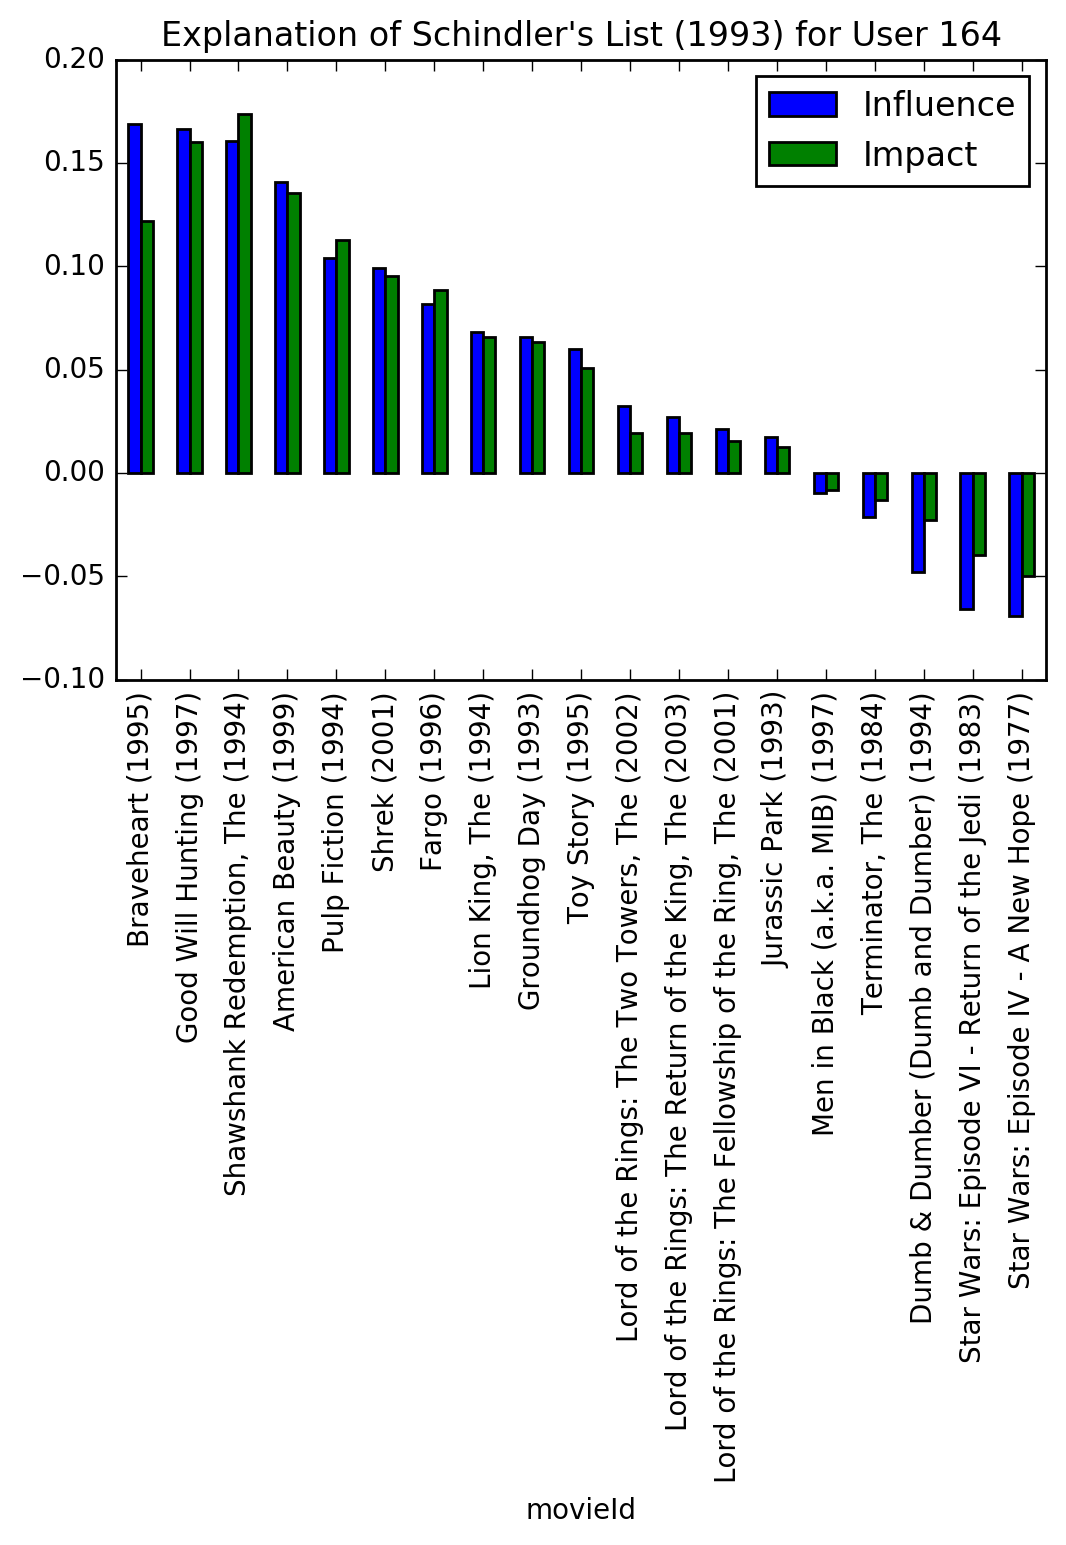

In [450]:
(rpt/rpt.sum())[['Influence','Impact']].sort_values('Influence',ascending=False).plot.bar()
_ = plt.title('Explanation of {} for User {}'.format(top_recom, user))

### What-if using Influence

Our user realizes that the recommendation is strongly influenced by _Braveheart_, and that the user is not sure she likes _Braveheart_ all that much.

The influence of _Braveheart_ is 0.176, so if the user downgraded her rating by 2 points, this should reduce the predicted score for _Schindler's List_ by 2 * 0.178 = 0.356.

Indeed:

In [451]:
ML_explainer.ratings.loc['Braveheart (1995)', user] -= 2.0
predictions = ML_explainer.fit_model()
rpt = ML_explainer.report_recommendation(ML_explainer.jacobian(user), user, top_recom)

User ID: 164
Recommendation: Schindler's List (1993)
Predicted rating: 3.97
Number of rated movies: 19

----------------------------------------------------------------------------
Rated Movie                         Influence    Known rating   Impact      
----------------------------------------------------------------------------
Braveheart (1995)                       0.178           1.0     0.178
Good Will Hunting (1997)                0.174           4.0     0.698
Shawshank Redemption, The (1994)        0.167           4.5     0.752
American Beauty (1999)                  0.147           4.0     0.587
Pulp Fiction (1994)                     0.108           4.5     0.485
Shrek (2001)                            0.103           4.0     0.413
Fargo (1996)                            0.083           4.5     0.375
Lion King, The (1994)                   0.070           4.0     0.281
Groundhog Day (1993)                    0.067           4.0     0.270
Toy Story (1995)                   

The system's recommendation is very sensitive to this change:

In [452]:
top_recom = ML_explainer.predictions(user).index.values[0]
print("The new top recommendation is '{}'".format(top_recom))

The new top recommendation is 'Usual Suspects, The (1995)'


In [453]:
rpt = ML_explainer.report_recommendation(ML_explainer.jacobian(user), user, top_recom)

User ID: 164
Recommendation: Usual Suspects, The (1995)
Predicted rating: 4.10
Number of rated movies: 19

----------------------------------------------------------------------------
Rated Movie                         Influence    Known rating   Impact      
----------------------------------------------------------------------------
Fargo (1996)                            0.230           4.5     1.035
Pulp Fiction (1994)                     0.214           4.5     0.965
American Beauty (1999)                  0.189           4.0     0.754
Shawshank Redemption, The (1994)        0.111           4.5     0.501
Star Wars: Episode IV - A New Hope      0.067           3.0     0.200
Terminator, The (1984)                  0.061           2.5     0.152
Star Wars: Episode VI - Return of       0.054           2.5     0.135
Groundhog Day (1993)                    0.051           4.0     0.203
Good Will Hunting (1997)                0.047           4.0     0.188
Jurassic Park (1993)            

### Influence vs Impact

In [454]:
# reset the model
ML_explainer = MF_explan.MF_explan(50)
predictions = ML_explainer.fit_model()
user = 164
top_recom = ML_explainer.predictions(user).index.values[0]
J_j = ML_explainer.jacobian(user)
rpt = ML_explainer.report_recommendation(J_j, user, top_recom, silent=True)

In [455]:
print(top_recom)
rpt.sort_values('Influence',ascending=False).head()
# rpt.sort_values('Impact',ascending=False).head()

Schindler's List (1993)


,Influence,Known Rating,Impact
movieId,,,
Braveheart (1995),0.175961,3.0,0.527883
Good Will Hunting (1997),0.173553,4.0,0.694214
"Shawshank Redemption, The (1994)",0.167394,4.5,0.753272
American Beauty (1999),0.146591,4.0,0.586363
Pulp Fiction (1994),0.108612,4.5,0.488752


## Flexibility

It's easy to ask about most influential items for a __set__ of recommendations, or even for all (unrated) items in the dataset.

["Schindler's List (1993)" 'Usual Suspects, The (1995)' 'Fight Club (1999)'
 'Forrest Gump (1994)' 'Silence of the Lambs, The (1991)']


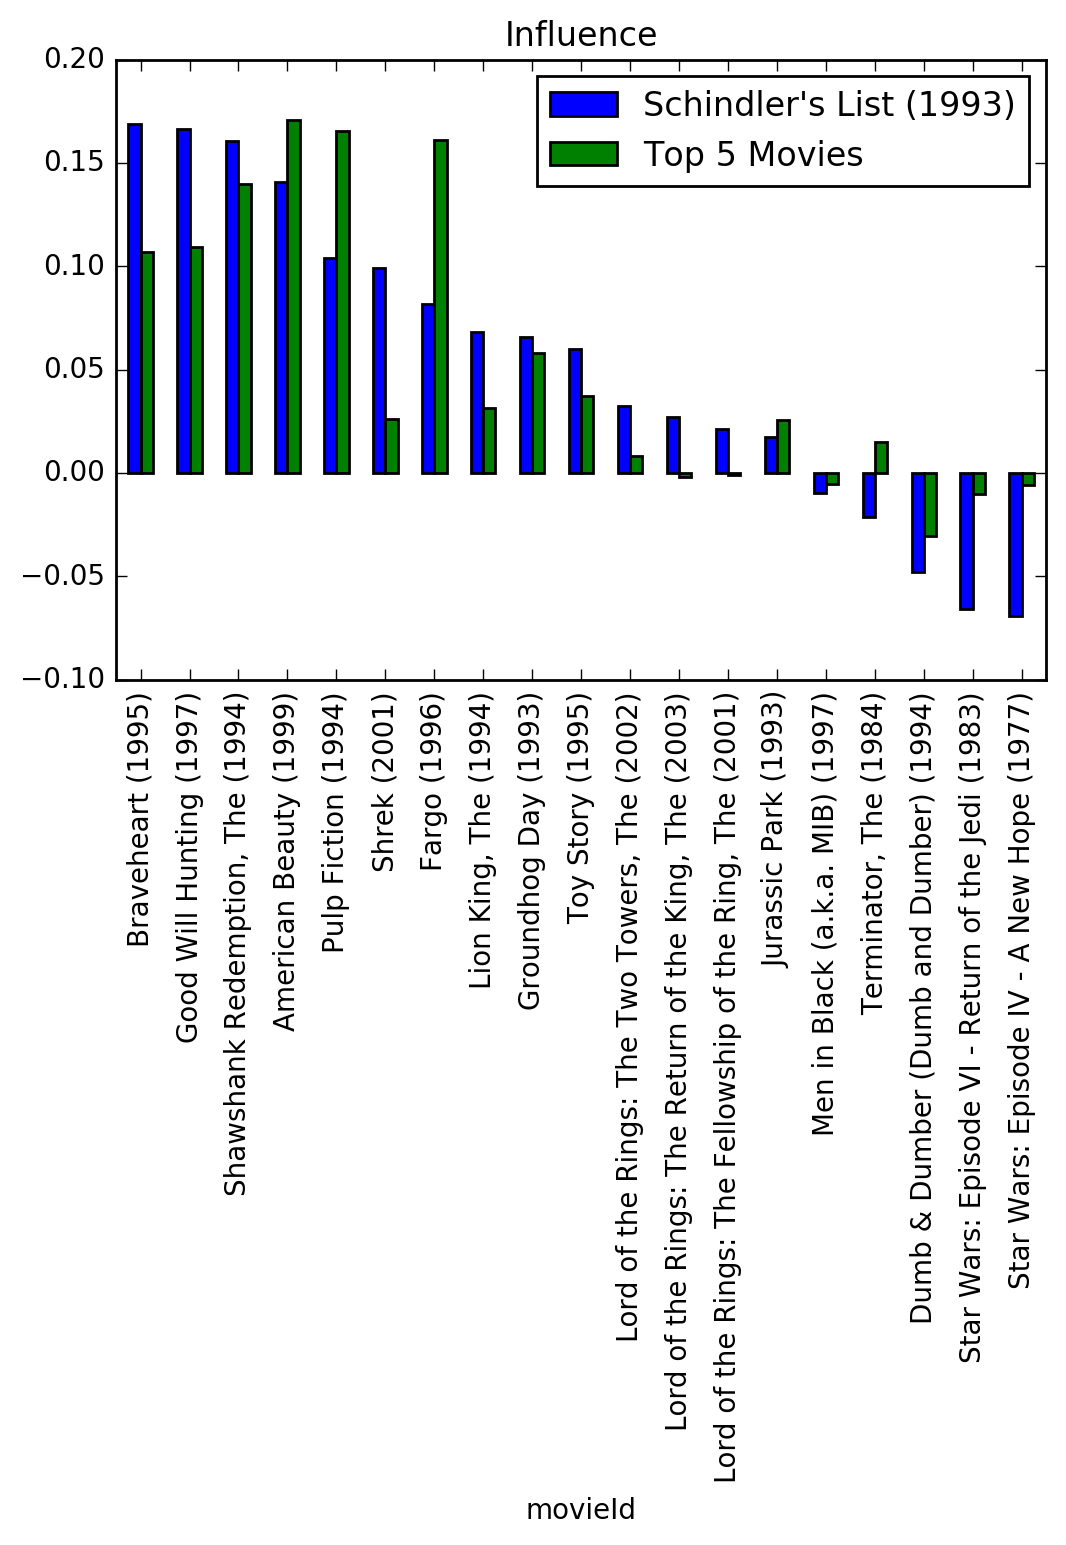

In [456]:
recom = ML_explainer.predictions(user).index.values[:5]
print(recom)
rpt_top5 = ML_explainer.report_recommendation(J_j, user, recom, silent=True)
compare = pd.concat([rpt['Influence'],rpt_top5['Influence']],axis=1)
compare.columns=[top_recom, 'Top 5 Movies']
(compare/compare.sum()).sort_values(top_recom,ascending=False).plot.bar()
_ = plt.title('Influence')

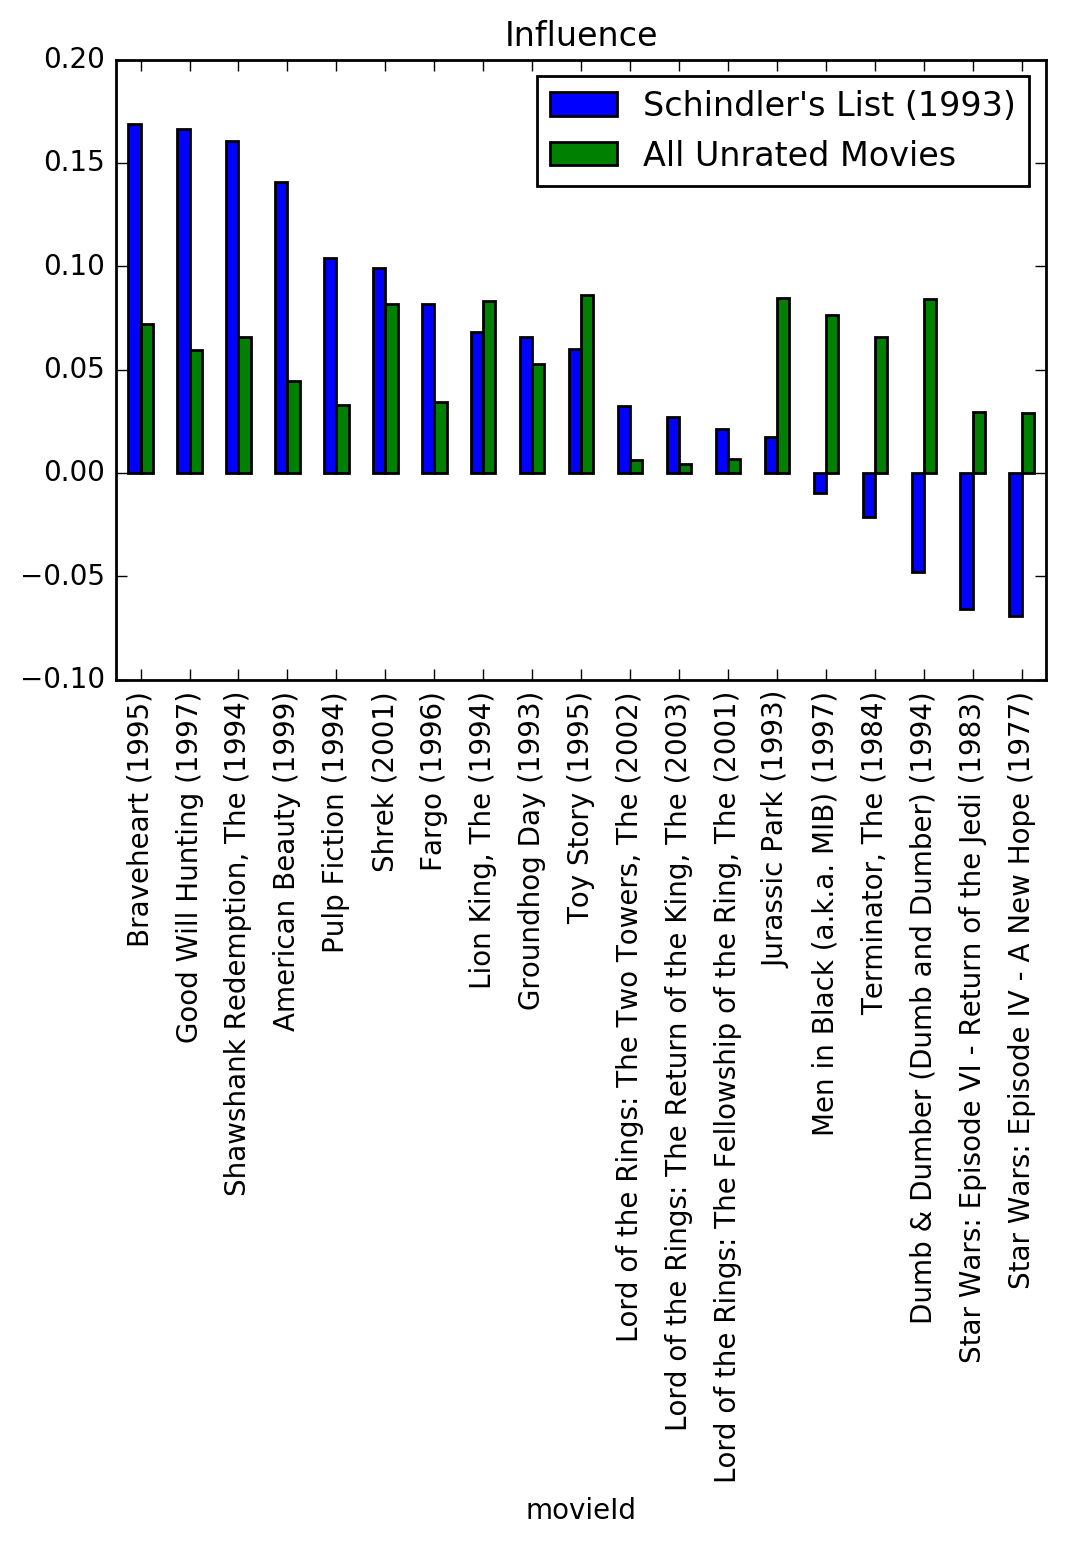

In [457]:
recom = ML_explainer.predictions(user).index.values
rpt_all = ML_explainer.report_recommendation(J_j, user, recom, silent=True)
compare = pd.concat([rpt['Influence'],rpt_all['Influence']],axis=1)
compare.columns=[top_recom, 'All Unrated Movies']
(compare/compare.sum()).sort_values(top_recom,ascending=False).plot.bar()
_ = plt.title('Influence')

## Conclusions

Are these useful?   They seem to be, but hard to be sure without more investigation.

It is interesting that the influence matrix only depends on __which__ movies the user has rated -- not what the ratings are.

So two users who have rated the same movies, will have the same influence matrix.

Next steps: what formal properties do these explanations satisfy?